<a href="https://colab.research.google.com/github/HannaKi/Finnish_sentiment_model/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip --quiet install transformers datasets

In [ ]:
%%bash

wget -nc -q https://korp.csc.fi/download/finsen/src/finsen-src.zip
unzip finsen-src.zip

In [ ]:
file_path = "/content/drive/MyDrive/FinnSentiment_with_BERT/model"
#!mkdir '{file_path}' # if you haven't created the folder before (note: you only need to do this once!)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np

import transformers
import datasets

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from time import time


In [5]:
fin_sent=pd.read_csv(
    r'/content/finsen-src/finsen-src/FinnSentiment2020.tsv',
    sep='\t',
    index_col=False, 
    header=None, 
    names=['A_sentiment','B_sentiment','C_sentiment','majority_value','derived_value','pre-annotated_smiley',
    'pre-annotated_review', 'split', 'batch', 'idx', 'text'],
)

In [6]:
mapping={1:'neg', 2:'neg', 3:'neut', 4:'pos', 5:'pos'}
fin_sent['label']=fin_sent.derived_value.map(mapping)
fin_sent.head()

,A_sentiment,B_sentiment,C_sentiment,majority_value,derived_value,pre-annotated_smiley,pre-annotated_review,split,batch,idx,text,label
0,1,0,1,1,4,0,-1,1,1,comments2008c.vrt 2145269,- Tervetuloa skotlantiin...,pos
1,0,1,0,0,4,0,-1,12,1,comments2011c.vrt 3247745,"...... No, oikein sopiva sattumaha se vaan oli...",pos
2,0,0,0,0,3,0,-1,14,1,comments2007c.vrt 3792960,40.,neut
3,1,1,1,1,5,0,1,7,1,comments2010d.vrt 2351708,Kyseessä voi olla loppuelämäsi nainen.,pos
4,1,1,1,1,5,0,1,12,1,comments2007d.vrt 1701675,Sinne vaan ocean clubiin iskemään!,pos


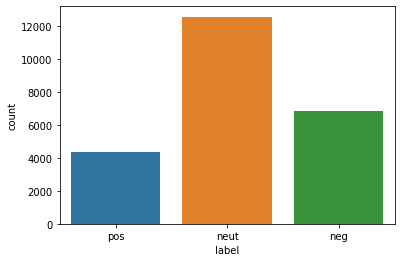

In [7]:
# Explore the label balance
sns.countplot(data=fin_sent, x='label'); # Not such a good balance...! 

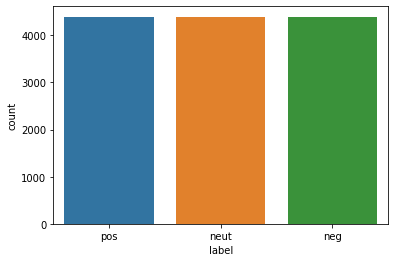

In [8]:
# downsize the data and balance classes # TODO: how to deal better with class imbalance!
pos=fin_sent[fin_sent.label=='pos']
neg=fin_sent[fin_sent.label=='neg']
neut=fin_sent[fin_sent.label=='neut']
neg=neg[:len(pos)]
neut=neut[:len(pos)]
test=pd.concat([pos, neut, neg])

sns.countplot(data=test, x='label'); 

# SVM baseline

In [9]:
from sklearn import svm

y=fin_sent['label']
X=fin_sent['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)#, random_state=123) # Note fixed random!

vectorizer=TfidfVectorizer() # TODO: Better params?
feature_matrix_train=vectorizer.fit_transform(X_train)
feature_matrix_test=vectorizer.transform(X_test)

cost=[]
acc=[]
t0 = time() # start timer
for C in (0.001,0.01,0.1,1,10,100):
    classifier=sklearn.svm.LinearSVC(C=C, max_iter=5000)
    classifier.fit(feature_matrix_train, y_train)
    # print(f"C={C}\t{classifier.score(feature_matrix_test, y_test):0.2f}")
    cost.append(C)
    acc.append(classifier.score(feature_matrix_test, y_test))
t1 = time() # end timer

print(f"Fitting and evaluating the model took {(t1-t0):0.2f} seconds.")

best_cost=cost[np.argmax(acc)]
svm_classifier=sklearn.svm.LinearSVC(C=best_cost, max_iter=5000)
svm_classifier.fit(feature_matrix_train, y_train)
preds=svm_classifier.predict(feature_matrix_test)

Fitting and evaluating the model took 22.28 seconds.


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model mean accuracy 0.6226541554959786


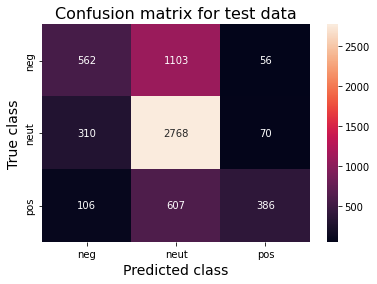

In [10]:
# Columns represent the predicted labels and the rows represent the real labels

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels=list(set(y_train)) # labels for the image, not for the data :)
labels.sort()

cf_mat=confusion_matrix(y_test, preds, labels=labels)

def plot_cf_matrix(mat):
  sns.heatmap(mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)#, annot_kws=m)
  plt.title("Confusion matrix for test data", fontsize = 16)
  plt.ylabel("True class", fontsize = 14)
  plt.xlabel("Predicted class", fontsize = 14)

plot_cf_matrix(cf_mat)

print(f"Model mean accuracy {svm_classifier.score(feature_matrix_test, y_test)}") # TODO: precision, recall, F1

# BERT

In [11]:
MODEL_NAME ='TurkuNLP/bert-base-finnish-cased-v1' # name from Hugging Face repository
BATCH_SIZE = 8 # Not optimized.
LEARNING_RATE = 2e-5 # Super important! Try this: 1e-5
TRAIN_EPOCHS = 1

In [12]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME) 

In [13]:
# Stratifying by column is only supported for ClassLabel column so make it!

class_names = ['pos', 'neut', 'neg']
dataset = datasets.Dataset.from_pandas(
  fin_sent[['text', 'label']], 
  #preserve_index=False, 
  features=datasets.Features( # provide the feature classes to make sure you get what you need
    {'text': datasets.Value('string'),
     'label': datasets.ClassLabel(names=class_names) # values 0, 1 and 2 
     }
     )
)

In [14]:
# is the data ok? take a look:
for i in range(5):
  print('Label:',dataset['label'][i], '\nFeedback:', dataset['text'][i])
  print()

Label: 0 
Feedback: - Tervetuloa skotlantiin...

Label: 0 
Feedback: ...... No, oikein sopiva sattumaha se vaan oli, vai mitä?

Label: 1 
Feedback: 40.

Label: 0 
Feedback: Kyseessä voi olla loppuelämäsi nainen.

Label: 0 
Feedback: Sinne vaan ocean clubiin iskemään!



In [15]:
# Split the data first in two parts. Note that this method shuffles the data and stratifies.

# Returns a dictionary (datasets.DatsetDict) with two random train and test subsets (train and test Dataset splits).
train_test = dataset.train_test_split(test_size=0.15, stratify_by_column='label') # 0.3

# Split the test data again to gain two datasets: one for development and one for testing
test_data = train_test['test'].train_test_split(test_size=0.5) # 0.2

# Store the data in a DatasetDict (so we can use a map function later to tokenize the data)
dataset = datasets.DatasetDict({
    'train': train_test['train'],
    'development': test_data['test'],
    'test': test_data['train']})

print(dataset) # check the splits

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20291
    })
    development: Dataset({
        features: ['text', 'label'],
        num_rows: 1791
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1790
    })
})


In [57]:
np.unique(dataset['train']['label']) # These are the label values from now on!

array([0, 1, 2])

In [16]:
# truncation = True: The tokenizer limits the input size to 512 tokens. See QA-code for longer input if needed!

def encode_dataset(d):
  return tokenizer(d['text'], max_length=512, truncation=True)#,return_tensors='pt') 


encoded_dataset = dataset.map(encode_dataset) #tokenize all of the data with map-method

  0%|          | 0/20291 [00:00<?, ?ex/s]

  0%|          | 0/1791 [00:00<?, ?ex/s]

  0%|          | 0/1790 [00:00<?, ?ex/s]

In [17]:
# encoded_dataset=encoded_dataset.remove_columns('text')
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20291
    })
    development: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1791
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1790
    })
})

In [18]:
def compute_metrics(pred):
    y_pred = pred.predictions.argmax(axis=1) 
    # we get the probability distribution out and the highest is selected with argmax
    y_true = pred.label_ids
    TP = len([a and b for a, b in zip(y_pred, y_true) if a == 1 and b == 1])
    TN = len([a and b for a, b in zip(y_pred, y_true) if a == 0 and b == 0])
    FN = len([a and b for a, b in zip(y_pred, y_true) if a == 0 and b == 1])
    FP = len([a and b for a, b in zip(y_pred, y_true) if a == 1 and b == 0])

    ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
    PRE = TP/(TP+FP) # Precision: share of relevant items
    REC = TP/(TP+FN) # Recall: proportion of relevant items found
    F1 = (2*((PRE*REC)/(PRE+REC))) # Balance between precision and recall
    return {'accuracy': ACC,
            'precision': PRE, 
            'recall': REC,
            'F1-score':F1
            }

In [19]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(set(fin_sent['label'])))

# Training arguments how to train, when to save the model weights
train_args = transformers.TrainingArguments(
    output_dir=file_path,
    save_strategy='epoch',
    evaluation_strategy='epoch', # look at the performence measures (accuracy, precision, recall, F1-score, what ever defined) after each epoch
    logging_strategy='epoch',
    learning_rate=LEARNING_RATE, 
    per_device_train_batch_size=BATCH_SIZE, 
    num_train_epochs=TRAIN_EPOCHS, 
    metric_for_best_model='F1-score', # use with Early Stopping callback
    load_best_model_at_end=True,      # restore the best model when training finishes
    weight_decay=0.01                # strength of weight decay
)

early_stopping = transformers.EarlyStoppingCallback(early_stopping_patience = 2)

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

In [20]:
trainer = transformers.Trainer(
    model,
    train_args,
    train_dataset = encoded_dataset['train'],
    eval_dataset = encoded_dataset['development'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[early_stopping]
)

In [21]:
trainer.train() 

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20291
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2537
  Number of trainable parameters = 124524291
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,0.558500,0.477648,0.915754,0.934389,0.951613,0.942922


***** Running Evaluation *****
  Num examples = 1791
  Batch size = 8
Saving model checkpoint to /content/BERT_model/checkpoint-2537
Configuration saved in /content/BERT_model/checkpoint-2537/config.json
Model weights saved in /content/BERT_model/checkpoint-2537/pytorch_model.bin
tokenizer config file saved in /content/BERT_model/checkpoint-2537/tokenizer_config.json
Special tokens file saved in /content/BERT_model/checkpoint-2537/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/BERT_model/checkpoint-2537 (score: 0.9429223744292238).


TrainOutput(global_step=2537, training_loss=0.558511182930134, metrics={'train_runtime': 379.2071, 'train_samples_per_second': 53.509, 'train_steps_per_second': 6.69, 'total_flos': 663798666496770.0, 'train_loss': 0.558511182930134, 'epoch': 1.0})

In [30]:
# save the model
# trainer.save_model(file_path)

Saving model checkpoint to /content/drive/MyDrive/FinnSentiment_with_BERT/model
Configuration saved in /content/drive/MyDrive/FinnSentiment_with_BERT/model/config.json
Model weights saved in /content/drive/MyDrive/FinnSentiment_with_BERT/model/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinnSentiment_with_BERT/model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinnSentiment_with_BERT/model/special_tokens_map.json


In [31]:
ml_metrics = trainer.evaluate() # check, that the best model was reloaded
print(ml_metrics)

***** Running Evaluation *****
  Num examples = 1791
  Batch size = 8


{'eval_loss': 0.4776480495929718, 'eval_accuracy': 0.9157540016849199, 'eval_precision': 0.9343891402714932, 'eval_recall': 0.9516129032258065, 'eval_F1-score': 0.9429223744292238, 'eval_runtime': 6.612, 'eval_samples_per_second': 270.87, 'eval_steps_per_second': 33.878, 'epoch': 1.0}


In [ ]:
#model = trainer.model
#model.to('cpu')    # simplifies input placement

#sentiment_label = [
#    'positive',
#    'neutral',
#    'negative',
#]

#def predict_sentiment(string):
#    tokenized = tokenizer(string, return_tensors='pt') # pytorch tensor
#    # print(tokenized)
#    pred = model(**tokenized) # ** place a dictionary as an argument
#    # pred  = model(input_ids=..., token_type_ids=..., attention_mask=...)
#    pred_idx = pred.logits.detach().numpy().argmax()
#    return sentiment_label[pred_idx]


In [ ]:
#example_sentences = [
#    'Upeaa',
#    'Rakastan koiria',
#    '40',
#    'TZZzzzzz',
#    'Olipa kamala päivä',
#]

#for e in example_sentences:
#    print(e, '->', predict_sentiment(e))

### eval with test data

In [32]:
test_results = trainer.predict(test_dataset=encoded_dataset['test'])

***** Running Prediction *****
  Num examples = 1790
  Batch size = 8


In [38]:
test_results.metrics

{'test_loss': 0.5152426362037659,
 'test_accuracy': 0.9110535405872193,
 'test_precision': 0.9294797687861271,
 'test_recall': 0.950354609929078,
 'test_F1-score': 0.9398012857977791,
 'test_runtime': 7.8269,
 'test_samples_per_second': 228.699,
 'test_steps_per_second': 28.619}

In [48]:
from collections import Counter

In [49]:
Counter(list(test_results.label_ids))

Counter({1: 929, 0: 331, 2: 530})

In [33]:
y_pred = np.argmax(test_results.predictions, axis=1) # array of predicted labels
y_true = encoded_dataset['test']['label'] # array of true labels

matrix=confusion_matrix(y_true, y_pred)
normalized = matrix/np.sum(matrix) # percentages
matrix # plain confusion matrix

array([[251,  61,  19],
       [ 42, 804,  83],
       [ 12, 160, 358]])

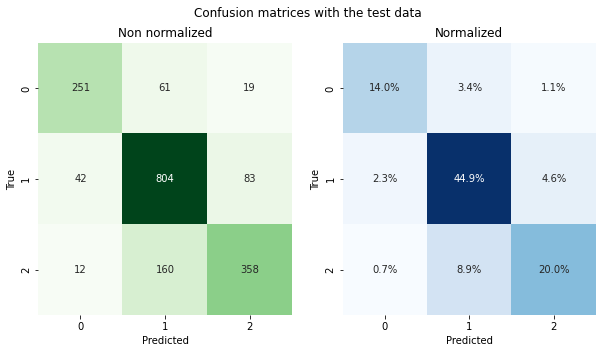

In [34]:
fig, axes  = plt.subplots(1,2, figsize=(10, 5))
fig.suptitle("Confusion matrices with the test data")
sns.heatmap(ax=axes[0], data=matrix, annot=True, cmap='Greens', fmt='d', cbar=False)
sns.heatmap(ax=axes[1], data=normalized, annot=True, cmap='Blues', fmt='.1%', cbar=False)
axes[0].set_title("Non normalized")
axes[0].set_ylabel("True")
axes[0].set_xlabel("Predicted")
axes[1].set_title("Normalized")
axes[1].set_ylabel("True")
axes[1].set_xlabel("Predicted");

In [50]:
test_results = pd.DataFrame(data=list(zip(encoded_dataset['test']['text'], y_pred.tolist(), y_true)), 
                            columns=['text', 'prediction', 'true'])

# successfully predicted entity relations in the test data:
TP = test_results[(test_results['true']==1) & (test_results['prediction']==1)]

for i, text in enumerate(TP['text']):
  print(i, text)

KeyError: ignored